In [1]:
#%pip install yfinance

In [1]:
import requests
import numpy as np
import pandas as pd
import yfinance as yf
import random
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt

In [2]:
def getTickerData(ticker, period, interval):
    hist = yf.download(tickers = ticker, period=period, interval=interval)
    df = pd.DataFrame(hist)
    df = df.reset_index()
    return df

In [3]:
df = getTickerData('btc-usd', 'max', '1d')
df = df.drop(columns={'Volume', 'Adj Close', 'Open', 'High', 'Low'})
df = df.rename(columns={'Close': 'close', 'Date': 'date'})
df['date'] = pd.to_datetime(df['date'])
df

[*********************100%***********************]  1 of 1 completed


,date,close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
3140,2023-04-23,27591.384766
3141,2023-04-24,27525.339844
3142,2023-04-25,28307.597656
3143,2023-04-26,28422.701172


In [4]:
rn = random.randint(0, df.value_counts().sum())
i=0
df.shape[0] - rn

3096

366.92401123046875


,date,close
49,2014-11-05,339.485992
50,2014-11-06,349.290009
51,2014-11-07,342.415009
52,2014-11-08,345.488007
53,2014-11-09,363.264008


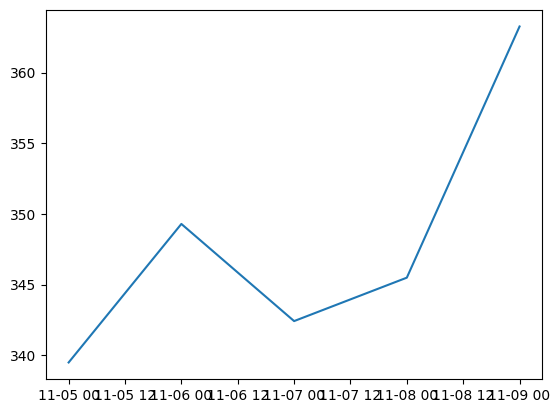

In [5]:
df2 = df.iloc[rn+i:rn+5+i,:]
final_value = df.iloc[rn+5+i]['close']
close_value = df.iloc[rn+4+i]['close']
plt.plot(df2['date'], df2['close'])
print(final_value)
i+=1
df2

In [282]:
class TradingEnv(Env):
    def __init__(self, df, n_steps, window_size) -> None:
        super().__init__()
        self.df = df.drop(columns={'date'})
        self.window_size = window_size
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(window_size, self.df.shape[1]))
        self.action_space = Discrete(2)
        self.done = None
        
        self.current_step = 0
        self.n_steps = n_steps
        self.random_index = random.randint(0, df.value_counts().sum())
        
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step]['close']
        self.next_value = df.iloc[self.random_index+self.window_size+self.current_step+1]['close']
        
        self.long_pos = []
        self.short_pos = []
        
    def step(self, action):
        if action == 0:
            self.short_pos.append(1)
            self.long_pos.append(0)
            if self.next_value < self.final_value:
                reward = 10
            else:
                reward = -100
        else:
            self.short_pos.append(0)
            self.long_pos.append(1)
            if self.next_value > self.final_value:
                reward = 10
            else:
                reward = -100
        
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step]['close']
        self.next_value = df.iloc[self.random_index+self.window_size+self.current_step+1]['close']
        self.current_step += 1
        
        if self.current_step > self.n_steps:
            done = True
        else:
            done = False
        
        observation = self.get_observation()
        info = {}
        
        return observation, reward, done, info
        
    def reset(self):
        self.random_index = random.randint(0, df.value_counts().sum())
        self.done = False
        self.current_step = 0
        return self.get_observation(is_random=True)
    
    def get_observation(self, is_random=False):
        needed_space = self.window_size + self.n_steps*2
        if is_random:
            self.random_index = random.randint(0, df.value_counts().sum())
            if df.shape[0] - self.random_index < needed_space:
                self.random_index = df.shape[0] - needed_space
        return self.df.iloc[self.random_index+self.current_step:self.random_index+self.window_size+self.current_step, :].values
    
    def calculate_reward():
        pass    

    def close():
        pass
    
    def render():
        pass
    
    def render_final():
        pass

In [283]:
env = TradingEnv(df, window_size=90, n_steps=20)

416.72900390625
417.9599914550781


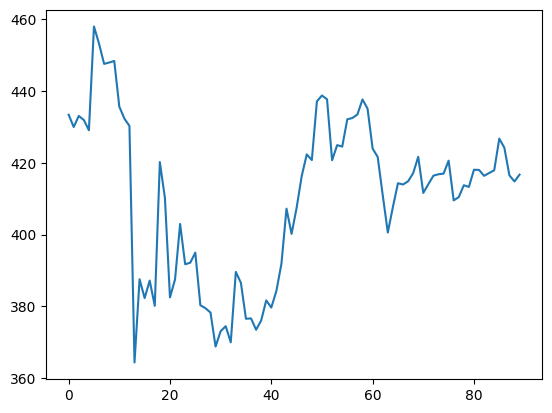

In [290]:
#env.reset()
obs, reward, done, info = env.step(0)
plt.plot(obs)
print(env.final_value)
print(env.next_value)

In [289]:
print(env.final_value)
print(env.next_value)

414.8160095214844
416.72900390625


In [288]:
env.get_observation()

array([[434.33401489],
       [433.43798828],
       [430.01098633],
       [433.09100342],
       [431.95999146],
       [429.10501099],
       [458.04800415],
       [453.23001099],
       [447.61099243],
       [447.99099731],
       [448.42800903],
       [435.69000244],
       [432.3710022 ],
       [430.30599976],
       [364.33099365],
       [387.53601074],
       [382.29901123],
       [387.16799927],
       [380.14898682],
       [420.23001099],
       [410.26199341],
       [382.49200439],
       [387.49099731],
       [402.9710083 ],
       [391.72601318],
       [392.15301514],
       [394.97198486],
       [380.28900146],
       [379.47399902],
       [378.25500488],
       [368.76699829],
       [373.05599976],
       [374.44799805],
       [369.94900513],
       [389.59399414],
       [386.54901123],
       [376.52200317],
       [376.61999512],
       [373.44699097],
       [376.0289917 ],
       [381.64898682],
       [379.6539917 ],
       [384.26300049],
       [391

In [292]:
episodes = 10
for n in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        score += reward
    print(f'episode - {n} || score - {score}')
    

episode - 1 || score - -1000
episode - 2 || score - -1110
episode - 3 || score - -670
episode - 4 || score - -1330
episode - 5 || score - -1110
episode - 6 || score - -1000
episode - 7 || score - -890
episode - 8 || score - -1000
episode - 9 || score - -1000
episode - 10 || score - -230


In [278]:
env.get_observation()

array([[23078.72851562],
       [23031.08984375],
       [23774.56640625],
       [22840.13867188],
       [23139.28320312],
       [23723.76953125],
       [23471.87109375],
       [23449.32226562],
       [23331.84765625],
       [22955.66601562],
       [22760.109375  ],
       [23264.29101562],
       [22939.3984375 ],
       [21819.0390625 ],
       [21651.18359375],
       [21870.875     ],
       [21788.203125  ],
       [21808.1015625 ],
       [22220.8046875 ],
       [24307.84179688],
       [23623.47460938],
       [24565.6015625 ],
       [24641.27734375],
       [24327.64257812],
       [24829.1484375 ],
       [24436.35351562],
       [24188.84375   ],
       [23947.4921875 ],
       [23198.12695312],
       [23175.375     ],
       [23561.21289062],
       [23522.87109375],
       [23147.35351562],
       [23646.55078125],
       [23475.46679688],
       [22362.6796875 ],
       [22353.34960938],
       [22435.51367188],
       [22429.7578125 ],
       [22219.76953125],
